In [1]:
!pip install embassy

ERROR: Could not find a version that satisfies the requirement embassy (from versions: none)
ERROR: No matching distribution found for embassy


In [2]:
## Importing necessary libraries and functions for the examples ##

from embassy import align_and_measure

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group


## Defining some functions for beatiful outputs ##

def beatiful_text(x):
    return "Translation Error : " + str(round(x['translation_error'], 4)) + "\n" \
           "Rotation Error    : " + str(round(x['rotation_error'], 4))    + "\n" \
           "Scale Error       : " + str(round(x['scale_error'], 4))       + "\n" \
           "Stability Error   : " + str(round(x['stability_error'], 4))   + "\n"

def beatiful_visualization(t, h):
    plt.figure(figsize = (27, 3))

    for i in range(5):
        ax = plt.subplot(1, 8, i+1)
        ax.scatter(t[i][:,0], t[i][:,1], color=['tab:blue', 'tab:green', 'tab:orange', 'tab:purple'], s = 40, zorder = 100)
        ax.grid(True)
        ax.set_xticks(np.arange(-5, 6))
        ax.set_yticks(np.arange(-5, 6))
        ax.set_xlim((-5,5))
        ax.set_ylim((-5,5))
        ax.set_title('{}{}'.format(h,i))
        if i > 0:
            ax.tick_params(axis='y', which='major', labelsize=0)
            ax.text(-5, -10, beatiful_text(align_and_measure(t[i-1], t[i])), fontsize=10)
            ax.text(-5, -10, "... with respect to {}{}".format(h, i-1), fontsize=9, style='italic')
        if i > 1:
            ax.tick_params(axis='y', which='major', labelsize=0)
            ax.text(-5, -15, beatiful_text(align_and_measure(t[i-2], t[i])), fontsize=10)
            ax.text(-5, -15, "... with respect to {}{}".format(h, i-2), fontsize=9, style='italic')

        if i > 2:
            ax.tick_params(axis='y', which='major', labelsize=0)
            ax.text(-5, -20, beatiful_text(align_and_measure(t[i-3], t[i])), fontsize=10)
            ax.text(-5, -20, "... with respect to {}{}".format(h, i-3), fontsize=9, style='italic')

        if i > 3:
            ax.tick_params(axis='y', which='major', labelsize=0)
            ax.text(-5, -25, beatiful_text(align_and_measure(t[i-4], t[i])), fontsize=10)
            ax.text(-5, -25, "... with respect to {}{}".format(h, i-4), fontsize=9, style='italic')



### Example #1
In this toy example, we will do demonstrations with fictitious embeddings of a dynamic system with 5 timesteps.

* t0 will be created arbitrarily.
* t1 will have some translation.
* t2 will have some rotation.
* t3 will have some scaling.
* t4 will have some noise.

We will visualize input embeddings, and calculate alignment and stability measures each timestep pair.

Then, we will align the original embeddings and do the same visualizations and error calculations.

Original Embeddings


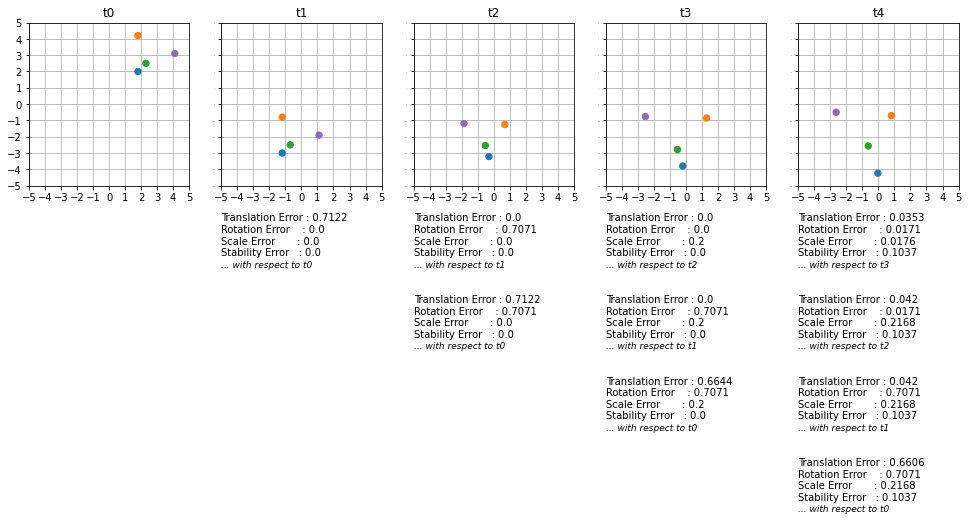

In [3]:
## Original Embeddings ##

t0 = np.array([[1.8, 2], [2.3, 2.5], [1.8, 4.2], [4.1, 3.1]]) # original embeddings
t1 = t0 + np.array([-3, -5]) # embeddings are shifted to a different region of the space
t2 = np.matmul((t1 - np.mean(t1,0)), ortho_group.rvs(dim=2)) + np.mean(t1,0) # embeddings are rotated around their center of gravity
t3 = ((t2 - np.mean(t2, 0)) * 1.5) + np.mean(t2, 0) # embeddings are scaled around their center of gravity
t4 = t3 + (np.random.rand(4, 2) - 0.5) # some random noise is introduced

t = [t0, t1, t2, t3, t4]

print('\033[1m' + 'Original Embeddings' + '\033[0m')
beatiful_visualization(t, 't')

In [18]:
t4

array([[-0.03591555, -4.23738503],
       [-0.63401225, -2.56682637],
       [ 0.81306153, -0.70559809],
       [-2.63458131, -0.49973038]])

In [20]:
from embassy import align_and_measure
import numpy as np

X = np.array([[ 1.8,  2.0], [2.3,   2.5], [1.8,   4.2], [ 4.1, 3.1]])
Y = np.array([[-0.0, -4.2], [-0.6, -2.6], [ 0.8, -0.7], [-2.6, 0.5]])

output = align_and_measure(X, Y)
             
print("\n Translation Error:", output['translation_error'], 
      "\n Rotation Error:",    output['rotation_error'],    
      "\n Scale Error:",       output['scale_error'],       
      "\n Stability Error:",   output['stability_error'],
      "\n",
      "\n X_aligned:\n",       output['emb1'],
      "\n",
      "\n Y_aligned:\n",       output['emb2'])



 Translation Error: 0.6367999168941216 
 Rotation Error: 0.7071067811865476 
 Scale Error: 0.2663024099899529 
 Stability Error: 0.12361196149464676 
 
 X_aligned:
 [[-0.7  -0.95]
 [-0.2  -0.45]
 [-0.7   1.25]
 [ 1.6   0.15]] 
 
 Y_aligned:
 [[-1.81152137 -1.75524651]
 [-0.45223065 -0.71971344]
 [-0.6267725   1.63390827]
 [ 2.89052453  0.84105168]]


Aligned Embeddings


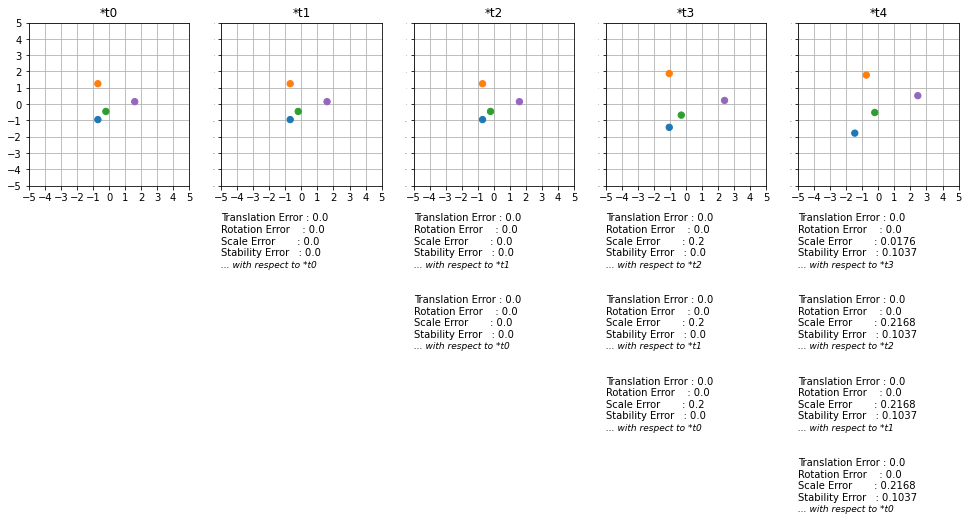

In [4]:
## Aligned Embeddings ##

t0_star = align_and_measure(t0, t1)['emb1']
t1_star = align_and_measure(t0_star, t1)['emb2']
t2_star = align_and_measure(t1_star, t2)['emb2']
t3_star = align_and_measure(t2_star, t3)['emb2']
t4_star = align_and_measure(t3_star, t4)['emb2']

t_star  = [t0_star, t1_star, t2_star, t3_star, t4_star]

print('\033[1m' + 'Aligned Embeddings' + '\033[0m')
beatiful_visualization(t_star, '*t')

### Example #2
In this example, we will do a calculate alignment and stability for _node2vec_ and _temporalnode2vec_ embeddings of the _aminer_ network. The method and the network is described in the paper.

In [5]:
import pandas as pd

for embmethod in ['node2vec', 'temporalnode2vec']:
    
    original_embs = []
    
    print('\033[1m', embmethod,  '\033[0m')
    
    for timestep in range(4): # read embeddings for each of the four consecutive snapshots of the aminer network
        emb = pd.read_csv('data/aminer_{}_{}.csv'.format(embmethod, timestep), header=None, index_col = 0).values
        original_embs.append(emb)


    for t_transition in range(3): # calculate alignment and stability errors for each timestep transition
        output = align_and_measure(original_embs[t_transition], original_embs[t_transition+1])
        print('\033[4m' + 'From timestep {} to timestep {}:'.format(t_transition, t_transition+1) + '\033[0m')
        print(beatiful_text(output))
        
    print('\n')

 node2vec 
From timestep 0 to timestep 1:
Translation Error : 0.3007
Rotation Error    : 0.6994
Scale Error       : 0.064
Stability Error   : 0.5894

From timestep 1 to timestep 2:
Translation Error : 0.3126
Rotation Error    : 0.734
Scale Error       : 0.0166
Stability Error   : 0.5667

From timestep 2 to timestep 3:
Translation Error : 0.2768
Rotation Error    : 0.7011
Scale Error       : 0.0422
Stability Error   : 0.58



 temporalnode2vec 
From timestep 0 to timestep 1:
Translation Error : 0.0637
Rotation Error    : 0.3537
Scale Error       : 0.0327
Stability Error   : 0.5795

From timestep 1 to timestep 2:
Translation Error : 0.0581
Rotation Error    : 0.377
Scale Error       : 0.0145
Stability Error   : 0.4876

From timestep 2 to timestep 3:
Translation Error : 0.0572
Rotation Error    : 0.3922
Scale Error       : 0.0186
Stability Error   : 0.5103



